**PRÁCTICA AI: Generación de imágenes mediante el uso de modelos de OpenChat 3.5 y Replicate.**

En este notebook, he desarrollado un flujo completo para la generación de imágenes mediante la API de Replicate, integrando previamente una etapa de optimización del prompt con ayuda de un modelo LLM llamado OpenChat 3.5.

OpenChat 3.5 es un modelo de lenguaje de código abierto, diseñado para producir texto altamente detallado y preciso. En este caso, lo utilizo como herramienta para convertir una descripción simple en un prompt enriquecido y elaborado, con el objetivo de mejorar significativamente la calidad de las imágenes generadas.

In [5]:
!pip install replicate transformers torch accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00


Configuración del Token de Replicate

Para proteger el token de Replicate, prefiero no escribirlo directamente en el código. En su lugar, uso la función getpass para pedirlo de forma interactiva al ejecutar el notebook.

El token se guarda temporalmente como una variable de entorno bajo el nombre REPLICATE_API_TOKEN, que es el método estándar para que la librería replicate se autentique.

Este enfoque me permite evitar que el token quede expuesto en el código fuente o en el historial del notebook, y previene posibles cargos inesperados en la cuenta de Replicate si el modelo se ejecuta accidentalmente.

In [6]:
import os

REPLICATE_API_TOKEN = input("Introduce tu token de Replicate: ")
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN


Introduce tu token de Replicate: r8_YqrmiSoF3u249w25NFRJrY6xG0zNuQ72MBlMn


En este bloque cargo el modelo de lenguaje **OpenChat 3.5** desde Hugging Face para generar texto optimizado a partir de descripciones simples.

Uso `AutoTokenizer` y `AutoModelForCausalLM` para preparar el modelo y su tokenizador. Luego creo un `pipeline` de generación de texto que automatiza todo el proceso de entrada y salida. El modelo se configura para aprovechar la GPU si está disponible, mejorando así el rendimiento. Este pipeline será clave para mejorar los prompts que alimentaré al generador de imágenes.


In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_name = "openchat/openchat-3.5-0106"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

llm_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Device set to use cuda:0



**Función `generate_image_with_replicate(prompt)`**

Esta función se encarga de generar imágenes con el modelo personalizado alojado en Replicate. A partir de un prompt, realiza una llamada a la API usando parámetros como resolución, pasos de inferencia y escala de guía. Devuelve las URLs de las imágenes generadas.





In [8]:
def generate_image_with_replicate(prompt):
    """
    Genera una imagen usando el modelo entrenado en Replicate de Jose.
    """
    output = replicate.run(
        "josemarin99/jose_face:a92eb7c5cfee6c1da820f9b263edbfbde53b49709a984086663eb140de054d5b",
        input={
            "prompt": prompt,
            "num_inference_steps": 30,
            "guidance_scale": 7.5,
            "width": 512,
            "height": 512
        }
    )
    return list(output)

**Función `optimize_prompt(prompt, trigger_word)`**

Optimiza el prompt del usuario con la ayuda de OpenChat 3.5, asegurando que la *trigger word* (como `jose_face`) se mantenga al principio.

Para ello, construye una instrucción especial en lenguaje natural que guía al modelo a generar un prompt más descriptivo, detallado y profesional. El resultado es un prompt enriquecido y adecuado para generar imágenes realistas con el modelo entrenado.

In [13]:
def optimize_prompt(prompt, trigger_word="jose_face"):
    """
    Optimiza un prompt usando OpenChat 3.5 y añade la trigger word correctamente al principio.
    """
    from transformers import pipeline

    system_prompt = (
        "You are an expert in crafting highly detailed and professional prompts for AI image generation models. "
        "The user will provide a short description, and you will rewrite it into a perfect prompt for image generation. "
        "Do not remove or change any special tokens such as trigger words like 'jose_face' if present in the original input."
    )

    # Le metemos ya la trigger word al input del user para que OpenChat la respete y la mejore
    forced_input = f"{trigger_word}, {prompt}"

    input_text = (
        f"<|im_start|>system\n{system_prompt}<|im_end|>\n"
        f"<|im_start|>user\n{forced_input}<|im_end|>\n"
        f"<|im_start|>assistant\n"
    )

    response = llm_pipeline(input_text, max_new_tokens=300, do_sample=True, temperature=0.7, top_p=0.9)
    optimized = response[0]['generated_text'].split("<|im_start|>assistant\n")[-1].strip()

    # Asegurar que la trigger word esté al inicio y sin alteraciones
    if not optimized.lower().startswith(trigger_word.lower()):
        optimized = f"{trigger_word}, {optimized}"

    return optimized


**Ejecución principal del flujo de generación de imágenes**

Este bloque orquesta todo el proceso: primero solicita al usuario una descripción básica. Luego, optimiza ese prompt con OpenChat 3.5, asegurando que incluya la *trigger word*.

A continuación, usa el prompt enriquecido para generar una o más imágenes con el modelo entrenado en Replicate.

Finalmente, imprime en consola las URLs de las imágenes generadas para poder visualizarlas o descargarlas.


In [14]:
import replicate

In [17]:
# ----- EJECUCIÓN PRINCIPAL ------

prompt_inicial = input("Introduce una descripción breve de la imagen que quieres generar: ")

# Paso 1: Optimizar el prompt con OpenChat
prompt_optimizado = optimize_prompt(prompt_inicial)

# Paso 2: Inyectar trigger word del modelo entrenado
prompt_optimizado = f"{prompt_optimizado}"

print("\nPrompt optimizado con trigger word:")
print(prompt_optimizado)

# Paso 3: Generar imagen con el modelo personalizado
imagenes = generate_image_with_replicate(prompt_optimizado)

# Paso 4: Visualizar imágenes
print("\nImágenes generadas:")
for img_url in imagenes:
    print(img_url)


Introduce una descripción breve de la imagen que quieres generar: Man playing chess

Prompt optimizado con trigger word:
jose_face, A man playing chess with intense concentration, wearing a suit and tie, in a well-lit room with a chessboard on a wooden table, a window in the background revealing a beautiful outdoor scene. The man's expression shows determination and focus as he considers his next move. The chess pieces are in various stages of play, with some pieces still in their original positions and others having been moved to create a dynamic and strategic scene. The man's hands are poised over the board, ready to make a move, and his eyes are locked on the pieces as he thinks. The atmosphere is serious and competitive, yet there is a sense of camaraderie between the man and his unseen opponent. The room is decorated with bookshelves and a few pieces of art, creating a cozy yet intellectual environment. The man's suit and tie suggest that he is a professional, and his demeanor ref

**Visualización y guardado de la imagen generada**

Este bloque se encarga de mostrar y guardar las imágenes creadas por el modelo de Replicate.

Comprueba si se generaron imágenes, y en ese caso, recorre cada URL descargando el contenido con `requests`.

Luego abre cada imagen con `PIL`, la muestra directamente en el notebook usando `matplotlib`, y finalmente la guarda localmente como `imagen_generada.png`. Si no se generaron imágenes, muestra un mensaje informativo en consola.


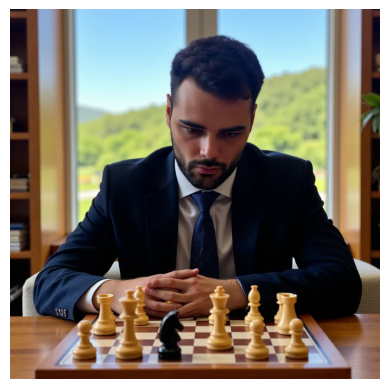

Imagen guardada como 'imagen_generada.png'


In [18]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


if imagenes:
    for img_url in imagenes:

        response = requests.get(img_url)


        image = Image.open(BytesIO(response.content))

        plt.imshow(image)
        plt.axis("off")
        plt.show()


        image.save("imagen_generada.png")
        print("Imagen guardada como 'imagen_generada.png'")
else:
    print("No se generaron imágenes.")
